## Train a VAE

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


cpu not relevant here
[500, 125, 31, 16, 16]
Epoch: 0, Loss: 88.13909870386124
Epoch: 1, Loss: 83.41870486736298
Epoch: 2, Loss: 81.95392549037933

Invalid parameters: data
Valid parameters are: config
dict_keys(['loss_absolute', 'loss_relative'])
Make plots


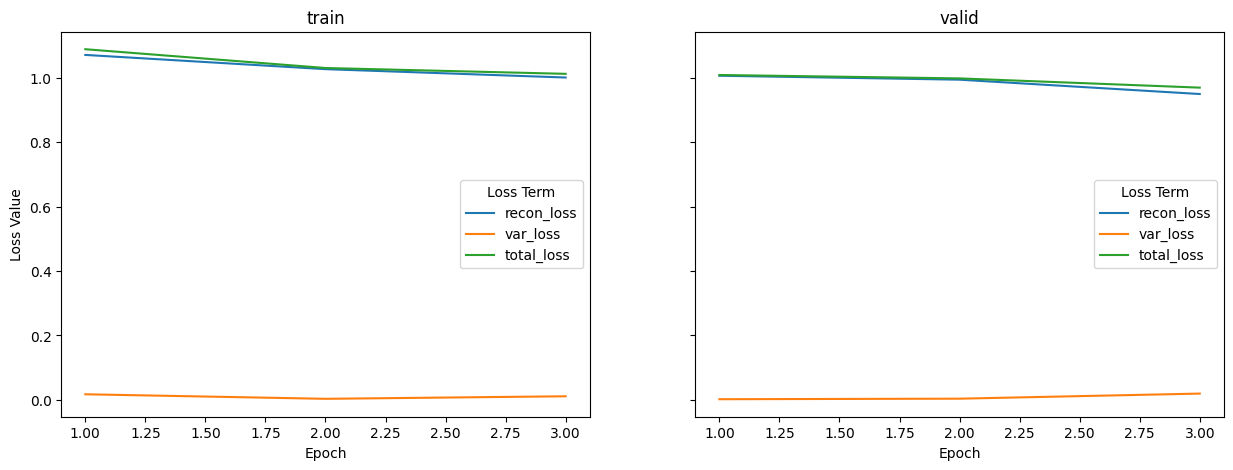

In [ ]:
from autoencodix.utils.default_config import DefaultConfig
import autoencodix as acx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


# sample_data = np.random.rand(1000, 100)
sample_data = pd.read_parquet('../data/RNA_data.parquet')
sample_data = sample_data.to_numpy()
my_config = DefaultConfig(learning_rate=0.001, epochs=25, checkpoint_interval=1, beta=0.5)
varix = acx.Varix(data=sample_data, config=my_config)
result = varix.run()

varix.show_result()
## Show 1-3 most relevant plots like loss, latent space, ... 

# result.plots.show_loss(type='relative)
## Show specific plot for relative loss contribution

# results.plots.save_plots(directory='./my_varix_plots/', which='all')
# results.plots.save_plots(directory='./my_varix_plots/', which=[])
## Save all plots to a specific directory


In [2]:
import autoencodix as acx
varix.visualize()
varix.show_result()

dict_keys([])
Make plots


In [2]:
loss_df_melt = pd.DataFrame()

for term in result.sub_losses.keys():
	loss_df = pd.DataFrame.from_dict(
		result.sub_losses.get(key=term).get(),
		orient='index'
		)
	## Make weighting of loss terms 
	if term == "var_loss":
		loss_df = loss_df *  varix.config.beta

	loss_df['Epoch'] = loss_df.index +1
	loss_df['Loss Term'] = term

	# print(loss_df)
	loss_df_melt = pd.concat([	loss_df_melt, 
								loss_df.melt(id_vars=['Epoch','Loss Term'], var_name='Split', value_name='Loss Value')],
								axis=0).reset_index(drop=True)


loss_df = pd.DataFrame.from_dict(
	result.losses.get(),
	orient='index'
		)
loss_df['Epoch'] = loss_df.index +1
loss_df['Loss Term'] = 'total_loss'
loss_df_melt = pd.concat([	loss_df_melt, 
							loss_df.melt(id_vars=['Epoch','Loss Term'], var_name='Split', value_name='Loss Value')],
							axis=0).reset_index(drop=True)
							
loss_df_melt['Loss Value'] = loss_df_melt['Loss Value'].astype(float)

In [3]:
result.sub_losses.keys()

dict_keys(['recon_loss', 'var_loss'])

In [4]:
my_config.get_params()['beta']

{'type': "<class 'float'>",
 'default': 0.1,
 'description': 'Beta weighting factor for VAE loss'}

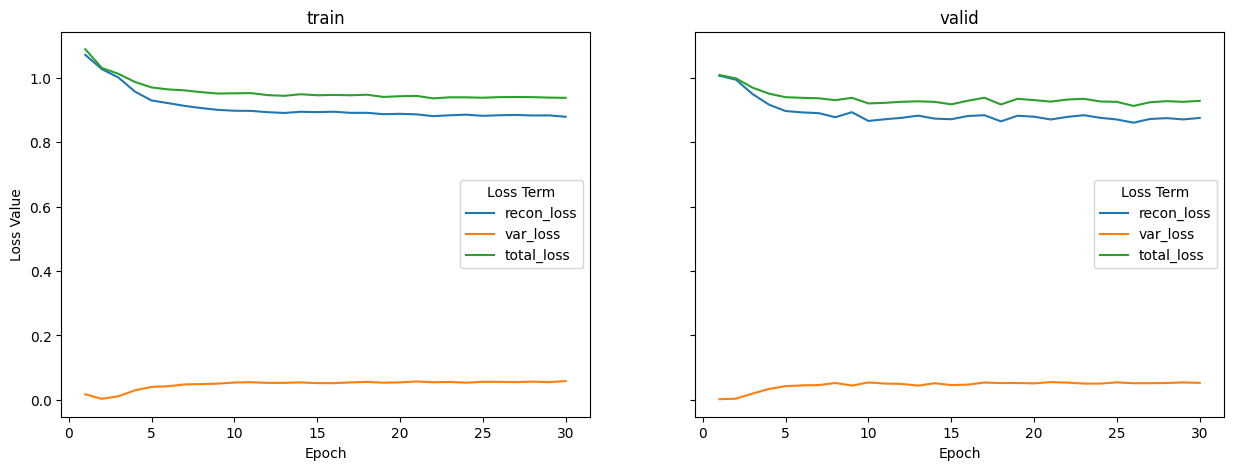

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax = 0

for split in loss_df_melt['Split'].unique():
	sns.lineplot(data=loss_df_melt[(loss_df_melt['Split'] == split)], x="Epoch", y="Loss Value", hue="Loss Term", ax=axes[ax])
	axes[ax].set_title(split)
	ax += 1

# sns.FacetGrid(loss_df_melt, col='Split', hue='Loss Term', height=5).map(sns.lineplot, 'Epoch', 'Loss Value').add_legend()

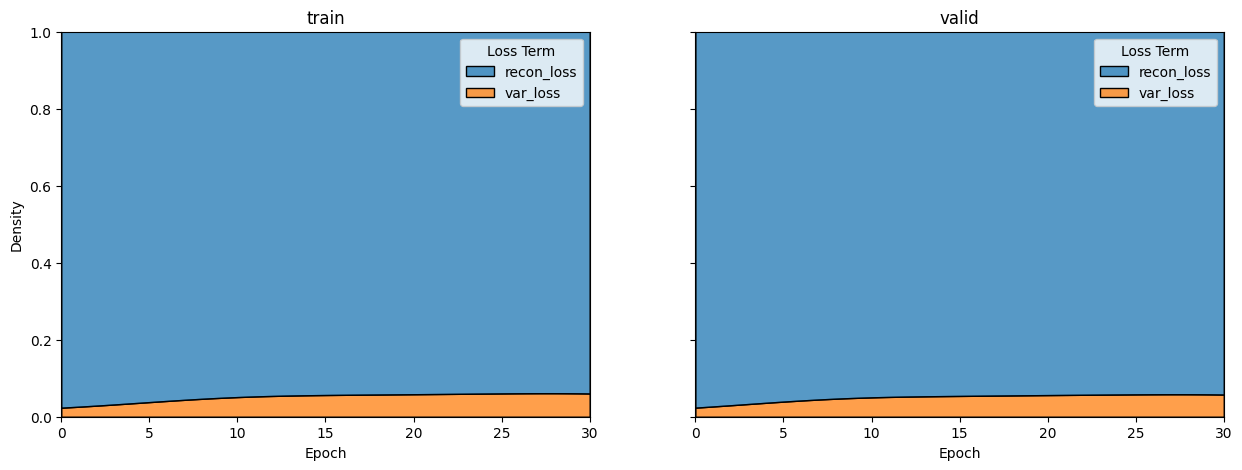

In [7]:
exclude = loss_df_melt['Loss Term'] != 'total_loss'

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax = 0

for split in loss_df_melt['Split'].unique():
	sns.kdeplot(data=loss_df_melt[exclude & (loss_df_melt['Split'] == split)], x="Epoch", hue="Loss Term", multiple="fill", weights="Loss Value",clip=[0,30], ax=axes[ax])
	axes[ax].set_title(split)
	ax += 1